#### Baseline Forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta, date, time
import calendar
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
color_pal = sns.color_palette()

#### Set parameters

In [2]:
# Set Parameters for Model Training and Evaluation
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
train_data_end = "2025-01-01"

periods = 4
test_start = "2024-02-22"
test_end = "2025-02-19"

#### Load Data

In [3]:
df = pd.read_csv('../data/combined_data/combined_bike_data.csv', parse_dates=["Datetime"], index_col="Datetime")

# define time zone as ezrope/berlin to account for time shifts in original data
df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Berlin')

# convert back to utc to remove time shifts
df.index = df.index.tz_convert('UTC')

# remove tz awareness
df.index = df.index.tz_localize(None)

#### Prepare and Clean Data for Model

#### Rolling Window and Model

In [4]:
data = df[["target"]].copy()
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

test_data = data.loc[test_start:test_end]

results = []

for timestamp in test_data.index:

    current_hour = timestamp.hour
    current_dayofweek = timestamp.dayofweek

    historical_data = data[
        (data.index < timestamp) &
        (data['hour'] == current_hour) &
        (data['dayofweek'] == current_dayofweek)
    ]


    if len(historical_data) < periods:
        continue

    historical_values = historical_data['target'].tail(periods).values

    quantile_forecast = np.quantile(historical_values, quantiles)

    results.append({
        "index": timestamp,
        "target": test_data.loc[timestamp, "target"],
        **{f"q{q}": qf for q, qf in zip(quantiles, quantile_forecast)}
    })

results = pd.DataFrame(results).set_index("index")
results.index.name = "Datetime"

In [5]:
# Resample to get daily values
results = results[['target', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']].resample('D').sum()

In [6]:
import os
folder = "results"
os.makedirs(folder, exist_ok=True)
results.to_csv(f"{folder}/Baseline Forecast.csv", index=True)
results

,target,q0.025,q0.25,q0.5,q0.75,q0.975
Datetime,,,,,,
2024-02-22,3284.0,3624.700,3973.00,4369.5,4718.50,4938.550
2024-02-23,4771.0,3554.775,3984.75,4377.0,4760.50,5166.850
2024-02-24,3351.0,2962.200,3081.00,3229.0,3415.75,3639.175
2024-02-25,1850.0,1323.025,1449.25,1561.5,1699.00,1893.400
2024-02-26,4518.0,4004.075,4301.75,4534.0,4711.25,4860.425
...,...,...,...,...,...,...
2025-02-15,2819.0,2898.800,3050.00,3257.5,3506.50,3769.750
2025-02-16,1329.0,1305.700,1438.00,1572.5,1714.25,1866.125
2025-02-17,4081.0,3479.300,3860.00,4115.5,4297.00,4477.900


<AxesSubplot:title={'center':'Baseline Forecast'}, xlabel='Datetime'>

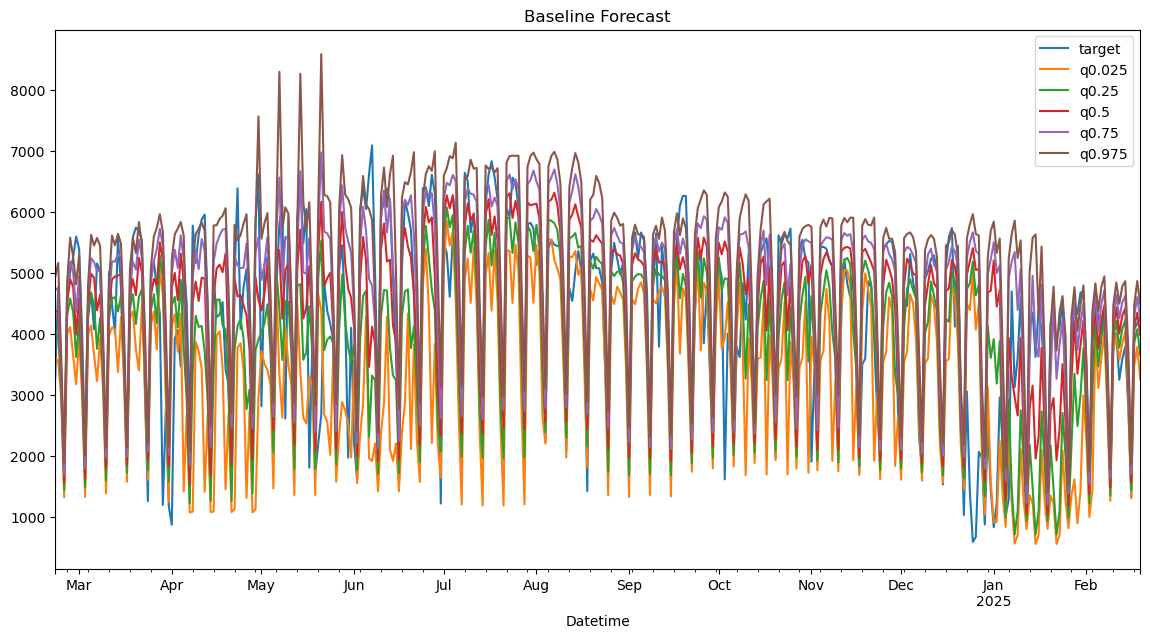

In [7]:
results.plot(y=["target","q0.025", "q0.25", "q0.5", "q0.75", "q0.975"], figsize=(14, 7), title="Baseline Forecast")

#### Evaluation

In [8]:
# calucate quantile losses of all predictions
quantile_losses = {}

for q in quantiles:
    
    y_pred = results[f'q{q}']
    y_true = results['target']
    
    # pinball loss function multiplied by 2
    quantile_loss = np.where(y_pred > y_true, 
                             2 * (1 - q) * (y_pred - y_true), 
                             2 * q * (y_true - y_pred))
    
    quantile_losses[f'Quantile_{q}'] = quantile_loss.mean()

# losses of all quantile
total_loss_score = sum(quantile_losses.values())

# show results
print("Average loss by quantile:")
for quantile, loss in quantile_losses.items():
    print(f"{quantile}: {loss}")

print(f"\nTotal loss score over all quantiles: {total_loss_score}")

Average loss by quantile:
Quantile_0.025: 350.78919299450547
Quantile_0.25: 723.4000686813187
Quantile_0.5: 749.2788461538462
Quantile_0.75: 512.8619505494505
Quantile_0.975: 120.58764423076929

Total loss score over all quantiles: 2456.91770260989


In [9]:
# filter only relevant target horizons
results['dayofweek'] = results.index.dayofweek

horizons_dict = {}

target_horizons = [
    {"dayofweek": 1, "name": "1 day"},  # Dienstag
    {"dayofweek": 2, "name": "2 day"},  # Mittwoch
    {"dayofweek": 3, "name": "3 day"},  # Donnerstag
    {"dayofweek": 4, "name": "4 day"},  # Freitag
    {"dayofweek": 5, "name": "5 day"},  # Samstag
    {"dayofweek": 6, "name": "6 day"},  # Sonntag
]


for horizon in target_horizons:

    horizon_data = results[(results["dayofweek"] == horizon["dayofweek"])]
    horizon_data = horizon_data.drop(columns=["dayofweek"])

    horizons_dict[horizon["name"]] = horizon_data

In [10]:
# quantile losses target horizons
def calculate_quantile_losses(horizons_dict, quantiles):
    all_quantile_losses = {}
    
    for key, df in horizons_dict.items():
        quantile_losses = {}
        for q in quantiles:
            y_pred = df[f'q{q}']
            y_true = df['target']
            quantile_loss = np.where(y_pred > y_true, 2 * (1 - q) * (y_pred - y_true), 2 * q * (y_true - y_pred))
            quantile_losses[f'q{q}'] = quantile_loss.mean()
        
        total_loss_score = sum(quantile_losses.values())
        quantile_losses['Total_Loss_Score'] = total_loss_score
        all_quantile_losses[key] = quantile_losses
    
    return all_quantile_losses

quantile_loss_results = calculate_quantile_losses(horizons_dict, quantiles)

horizon_results_df = pd.DataFrame(quantile_loss_results).T
horizon_results_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total_Loss_Score
1 day,404.534159,807.588942,772.778846,453.877404,87.418966,2526.198317
2 day,362.312260,798.350962,826.913462,597.137019,133.910793,2718.624495
3 day,524.736995,1051.699519,1071.826923,715.038462,151.879808,3515.181707
4 day,458.526370,850.512019,859.230769,590.550481,155.812813,2914.632452
5 day,135.943894,446.197115,558.894231,410.550481,107.573486,1659.159207
6 day,96.723173,304.788462,373.201923,289.711538,86.317885,1150.742981


#### Final Evaluation Score

In [11]:
horizon_results_df.sum()

q0.025               1982.776851
q0.25                4259.137019
q0.5                 4462.846154
q0.75                3056.865385
q0.975                722.913750
Total_Loss_Score    14484.539159
dtype: float64